# Mean filter

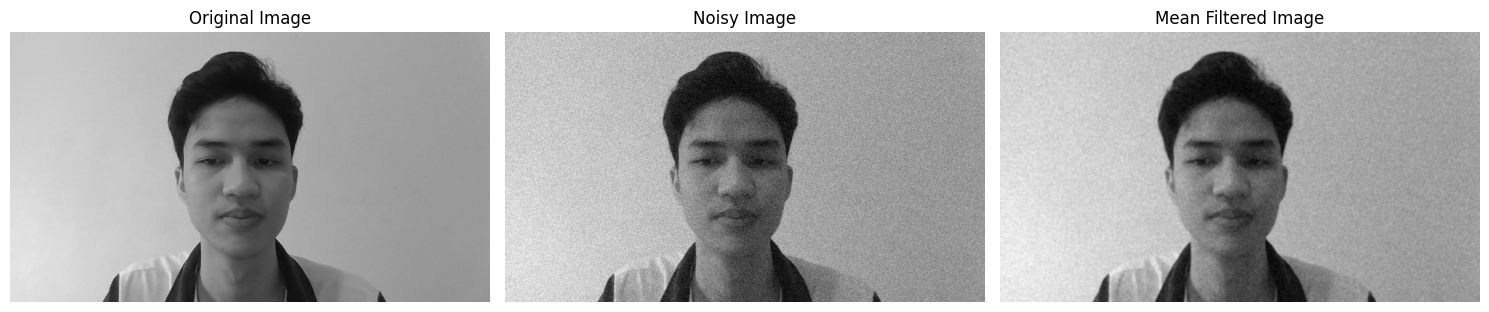

Images saved to D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\output\mean_filtering


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class ImageProcessingConfig:
    """Configuration for image processing parameters."""
    kernel_size: int = 5
    noise_stddev: float = 25.0
    mean_filter_size: int = 5
    figure_size: Tuple[int, int] = (15, 5)

class ImageProcessor:
    """Handles image loading, processing, and saving."""
    
    def __init__(self, input_path: str, output_dir: str, config: ImageProcessingConfig = ImageProcessingConfig()):
        self.input_path = input_path
        self.output_dir = output_dir
        self.config = config
        self.original_image: Optional[np.ndarray] = None

    def load_image(self) -> bool:
        """Load a grayscale image from the input path."""
        try:
            self.original_image = cv2.imread(self.input_path, cv2.IMREAD_GRAYSCALE)
            if self.original_image is None:
                raise FileNotFoundError(f"Image not found at: {self.input_path}")
            return True
        except FileNotFoundError as e:
            print(f"Error: {e}")
            return False
        except Exception as e:
            print(f"Unexpected error loading image: {e}")
            return False

    @staticmethod
    def add_gaussian_noise(image: np.ndarray, mean: float = 0, stddev: float = 25.0) -> np.ndarray:
        """Add Gaussian noise to an image."""
        noise = np.random.normal(mean, stddev, image.shape)
        noisy_image = image + noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    @staticmethod
    def apply_mean_filter(image: np.ndarray, filter_size: int = 5) -> np.ndarray:
        """Apply a mean filter to an image."""
        kernel = np.ones((filter_size, filter_size), np.float32) / (filter_size ** 2)
        return cv2.filter2D(image, -1, kernel)

    def process_image(self) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
        """Apply blur, noise, and mean filter to the image."""
        if self.original_image is None:
            return None, None, None
        
        blurred = cv2.GaussianBlur(self.original_image, 
                                 (self.config.kernel_size, self.config.kernel_size), 
                                 0)
        noisy = self.add_gaussian_noise(blurred, stddev=self.config.noise_stddev)
        filtered = self.apply_mean_filter(noisy, filter_size=self.config.mean_filter_size)
        return blurred, noisy, filtered

    def save_images(self, images: list[tuple[str, np.ndarray]]) -> None:
        """Save images to the output directory."""
        try:
            os.makedirs(self.output_dir, exist_ok=True)
            for name, image in images:
                output_path = os.path.join(self.output_dir, f"{name}.jpg")
                cv2.imwrite(output_path, image)
            print(f"Images saved to {self.output_dir}")
        except Exception as e:
            print(f"Error saving images: {e}")

def display_images(images: list[tuple[str, np.ndarray]], figure_size: Tuple[int, int]) -> None:
    """Display images side by side using matplotlib."""
    plt.figure(figsize=figure_size)
    for idx, (title, image) in enumerate(images, 1):
        plt.subplot(1, len(images), idx)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    """Main function to orchestrate image processing."""
    config = ImageProcessingConfig()
    input_path = r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\1.jpg'
    output_dir = r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\output\mean_filtering'

    processor = ImageProcessor(input_path, output_dir, config)
    
    if not processor.load_image():
        print("Exiting due to image loading failure.")
        return

    blurred, noisy, filtered = processor.process_image()
    if blurred is None or noisy is None or filtered is None:
        print("Image processing failed.")
        return

    # Display images
    images_to_display = [
        ("Original Image", processor.original_image),
        ("Noisy Image", noisy),
        ("Mean Filtered Image", filtered)
    ]
    display_images(images_to_display, config.figure_size)

    # Save images
    images_to_save = [
        ("original_image", processor.original_image),
        ("noisy_image", noisy),
        ("filtered_image", filtered)
    ]
    processor.save_images(images_to_save)

if __name__ == "__main__":
    main()